<a href="https://colab.research.google.com/github/yusrialsanaani/Interpretability_of_Machine_Learning_Models/blob/main/XGB_RF_SHAP_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Models Interpretability

The **objective** of this project is to introduce the explainable AI methods such as **SHAP** and **LIME**. These methods allow to explain and interpret the predictions of machine learning models, hence providing insight into the criteria behind predictions of machine learning models.

The main **Importance of Interpretability** is to allow us to perform error analysis and building a trust.
- Perform Error Analysis: allows to work specifically on weak points and to counteract them when training a model.
- Building a trust: many machine learning applications require trust in them so that the application can help with making a decision. Knowing the reasons for a prediction makes the decision to trust the application easier.

## Dataset
The dataset used in this project is Parkinsons Data Set taken from https://archive.ics.uci.edu/ml/datasets/parkinsons.
- This dataset is based on voice measures in frequency. 
- It was produced and released by the University of Oxford, available in the UCI ML Repository. 
- The dataset consists of 22 features and 1 result column of the diagnosis. 
- There are a total of 195 rows. Moreover, the dataset has been created from a measure of dysphonia and pitch period entropy.

## Interpretability Workflow
The general workflow of Interpretability is shown in the figure below.
The normal flow is to train a model with data and get predictions, then define an explainer and ingest both the data and the trained model to to it.
The defined explainer can provide Global or local interpretability.
- Global interpretability: This reflects the general behavior of the features in the model and allow us to understand which are the features that most impact the final output and of how much.
- Local interpretability: This shows the specific behavior of the features in a single model prediction, allowing us to understand all their single impacts on the final output. 

**LIME** is an example of explainers that provide **Local Interpretability**, while **SHAP** is an example of explainers that provide both **Local and Global Interpretabilities**.

SHAP explainers depends on Shap values. Shap values calculated based on the impact and contribution of each feature toward the prediction.
SHAP provides interpretabilities using different ways through different plots. Each plot will represent the impact, contribution of features in different ways providing both local and global  


![image](https://user-images.githubusercontent.com/89004966/166139599-8f9596be-0656-4abd-b6d3-7e41bcb61719.png)





## Importing required libraries

In [1]:
# Basics
import numpy as np
import pandas as pd

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from math import cos, sin, atan
from sklearn.utils import class_weight

# Metrics:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, precision_score, recall_score
from imblearn.metrics import specificity_score, sensitivity_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
# set the plot theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='talk', style="ticks", rc=custom_params)

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL_Project/parkinsons.data')

In [5]:
df.head()

name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.06545  0.02211  21.033       1  0.414783  0.815285 -4.813031   
1      0.09403  0.01929  19.085       1  0.458359  0.819521 -4.075192   
2      0.08270  0.01309  20.651       1  0.429895  0.825288 -4.443179   
3      0.08771  0.01353  20.644       1  0.434969  0.819235 -4.117501   
4      0.10470  0.01767  19.649       1  0.417356  0.823484 -3.747787   

    spread2        D2       PPE  
0  0.266482  2.301442  0.284654  
1  0.335590  2.486855  0.368674  
2  0.311173  2.342259  0.332634  
3  0.334147  2.405554  0.368975  
4  0.234513  2.332180  0.410335  

[5 rows x 24 columns]

## Define features vector X and target variable y

In [6]:
# Define features vector X and target variable y
X = df.drop(['name','status'], axis=1)
y = df.status

In [7]:
feature_names = X.columns
feature_names

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')

## Features normalizing

In [8]:
# Features normalizing
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
X = pd.DataFrame(X, columns = feature_names)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)

In [11]:
# Functions to calculate the classification metrics: Accuracy, Sensitivity, Specificity, 
# roc_auc, Confusion matrix, and Classification report
def classification_metrics(y_test_pred, y_train_pred, y_train, y_test, model_name):
    # Model Accuracy
    model_accur = accuracy_score(y_test, y_test_pred)
    # Training accuracy
    training_accur = accuracy_score(y_train, y_train_pred)
    # Test accuracy
    test_accur = accuracy_score(y_test, y_test_pred)
    # Sensitivity
    sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    # Specificity
    specificity = recall_score(y_test, y_test_pred, pos_label=0)
    # roc_auc
    roc_auc = roc_auc_score(y_test, y_test_pred)
    
    model = {'Model': model_name, 'Training Accuracy': training_accur,
             'Test Accuracy': test_accur,'Sensitivity':sensitivity,
             'Specificity':specificity, 'ROC_AUC':roc_auc}
    model_df = pd.DataFrame(model, index=[0])
    #display(NB_model_df)
    
    print('The accuracy score of {}: {:.3f}'.format(model_name, model_accur))
    print("\nTraining accuracy of {}: {:.3f}".format(model_name, training_accur))
    print("\nTest accuracy of {}: {:.3f}".format(model_name, test_accur))
    print("\nSensitivity Score of {}: {:.3f}".format(model_name, sensitivity))
    print("\nSpecificity Score of {}: {:.3f}".format(model_name, specificity))
    print("\nThe roc_auc of {}: {:.3f}".format(model_name, roc_auc))
    # Classification report
    print("\nClassification report:\n\n", classification_report(y_test,y_test_pred))
    print('Confusion Matrix:')
    
    # Confusion matrix
    font = {'family': 'serif','color':  'darkred','weight': 'bold','size': 12}
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    #plt.figure(figsize=(8,5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens",fmt='d')
    plt.ylabel('Predicted',fontdict=font)
    plt.xlabel('Actual',fontdict=font)
    plt.title('Confusion Matrix',fontdict=font)
    plt.xticks(fontsize=12);plt.yticks(fontsize=12)
    plt.show()
    print('Summary of classification metrics:')
    display(model_df)
    return model_df

# Create a function to plot roc_curve
def roc_curve_plot(X_test, y_test, model, model_name):
    # Calculating the false positive and true positive rates
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    FP_rate, TP_rate, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(10,6))
    plt.plot(FP_rate, TP_rate, label=f'{model_name} (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC for '+model_name+' Classifier')
    plt.legend(loc="lower right")
    plt.show()

## Extreme Gradient Boosting

In [12]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier()

In [13]:
#Predict Output
y_test_pred_XGB = model.predict(X_test)
y_train_pred_XGB = model.predict(X_train)

The accuracy score of XGB: 0.974

Training accuracy of XGB: 1.000

Test accuracy of XGB: 0.974

Sensitivity Score of XGB: 1.000

Specificity Score of XGB: 0.900

The roc_auc of XGB: 0.950

Classification report:

               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.97      1.00      0.98        29

    accuracy                           0.97        39
   macro avg       0.98      0.95      0.97        39
weighted avg       0.98      0.97      0.97        39

Confusion Matrix:


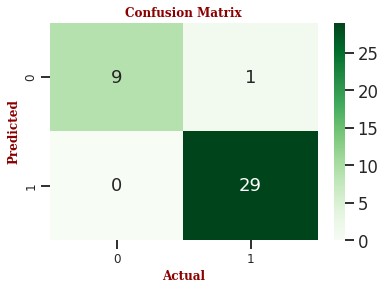

Summary of classification metrics:


Model  Training Accuracy  Test Accuracy  Sensitivity  Specificity  ROC_AUC
0   XGB                1.0       0.974359          1.0          0.9     0.95

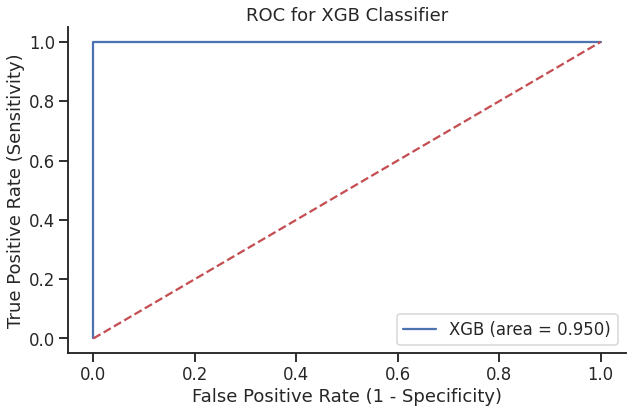

In [14]:
# Obtain Classification Mterics
model_name = 'XGB'
XGB_df = classification_metrics(y_test_pred_XGB, y_train_pred_XGB, y_train, y_test,model_name)
model_name = 'XGB'
roc_curve_plot(X_test, y_test, model,model_name)

#**XGBOOST Classifier With SHAP Interpretability**

In [15]:
!pip install dash
!pip install shap

     |████████████████████████████████| 9.6 MB 25.4 MB/s 
     |████████████████████████████████| 357 kB 71.6 MB/s 
     |████████████████████████████████| 564 kB 30.1 MB/s 


In [16]:
import shap

##**Visualize a single prediction - Local Interpretability**
>**How did each feature in the data affect that particular prediction?**

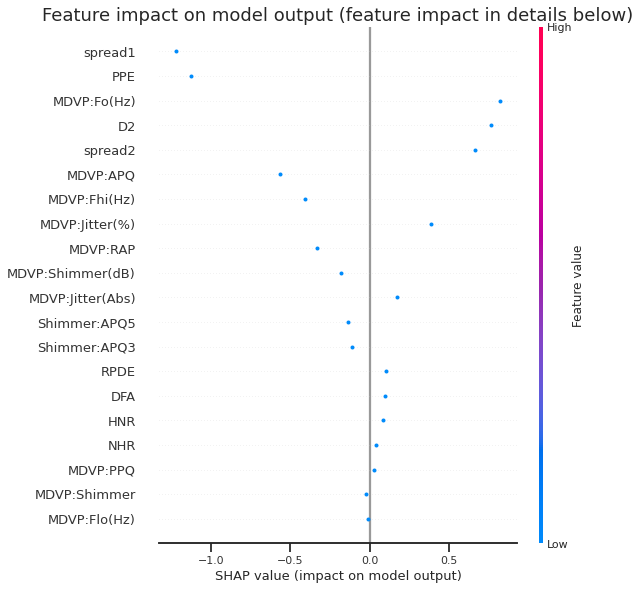

In [17]:
# Pick an arbitrary row (row  10)
row_to_show = 10
data_for_prediction = X_test.iloc[[row_to_show]]
#data_for_prediction = X_test

# Generate prediction
y_sample = model.predict(data_for_prediction)

# Create object that can calculate Shap values
explainer1 = shap.TreeExplainer(model)

# Calculate Shap values from prediction
shap_values1 = explainer1.shap_values(data_for_prediction)
plt.title('Feature impact on model output (feature impact in details below)')
shap.summary_plot(shap_values1, data_for_prediction)

# Plot the force plot
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1, data_for_prediction)
#shap.force_plot(explainer1.expected_value, shap_values1, data_for_prediction,matplotlib=True)

- In the plot above, the bold **0.680** is the model’s score for this observation. 
 - Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. 
- The base value = 1.602
 - This is the value would be predicted if we didn’t have any features for the current output.
- The features that were important to making the prediction for this observation are shown in **$\color{red}{\text{red}}$** and **$\color{blue}{\text{blue}}$**, with **$\color{red}{\text{red}}$** representing features that pushed the model score higher, and **$\color{blue}{\text{blue}}$** representing features that pushed the score lower. 
- Features that had more of an impact on the score are located closer to the dividing boundary between **$\color{red}{\text{red}}$** and **$\color{blue}{\text{blue}}$**, and the size of that impact is represented by the **size of the bar**.


##**Bar chart of mean importance - Global Interpretability**


**What features in the data did the model think are most important?**
 - We can use importance plot that takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.
 - The SHAP bar plot lets us specify how many predictors to display, and sum up the tail predictors, so informing us the collective contribution of the tail predictors.

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

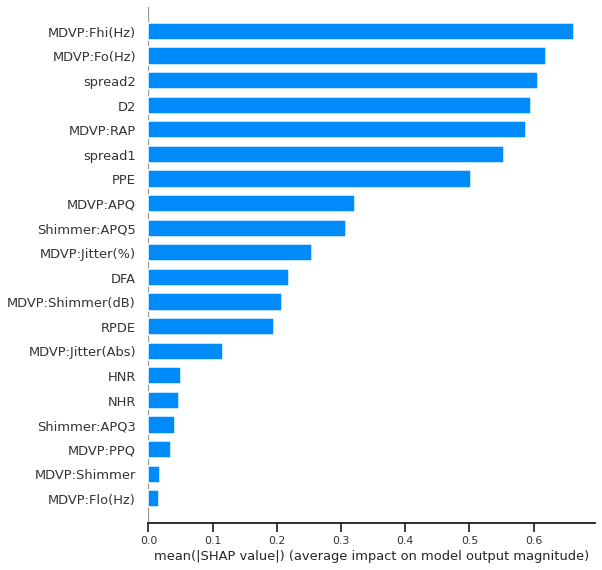

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

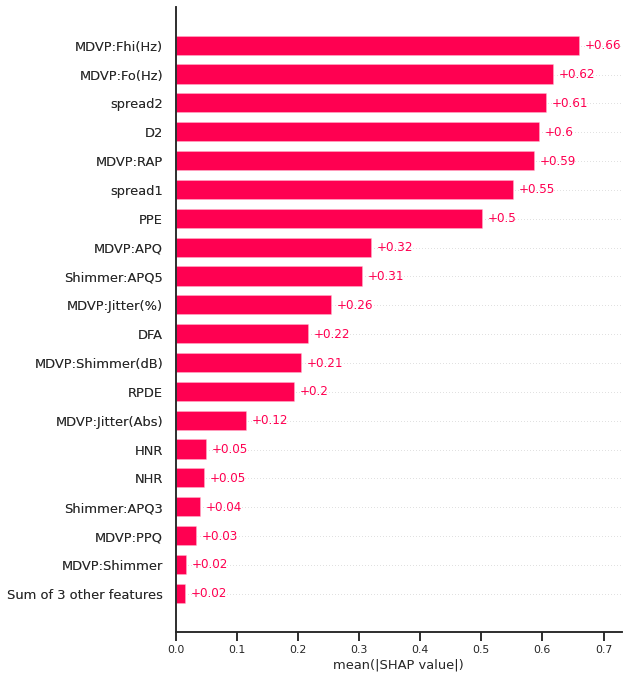

In [ ]:
# Bar plot for feature importance
explainer_bar = shap.Explainer(model)
shap_values_bar = explainer_bar(X_test)
shap.plots.bar(shap_values_bar,max_display=20) # default is max_display=10


**For a single prediction, we can plot what features in the data did the model think are most important?**

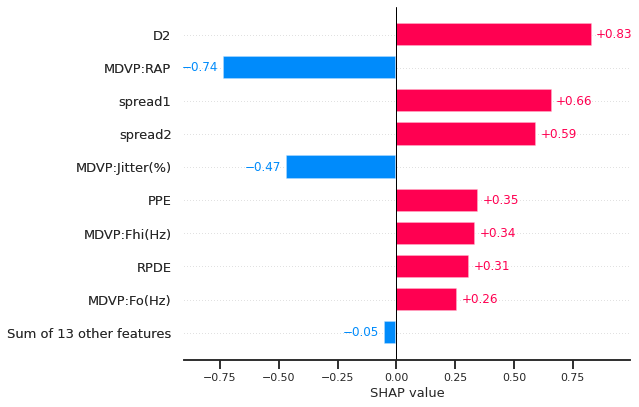

In [ ]:
shap.plots.bar(shap_values_bar[0]) # For the first observation


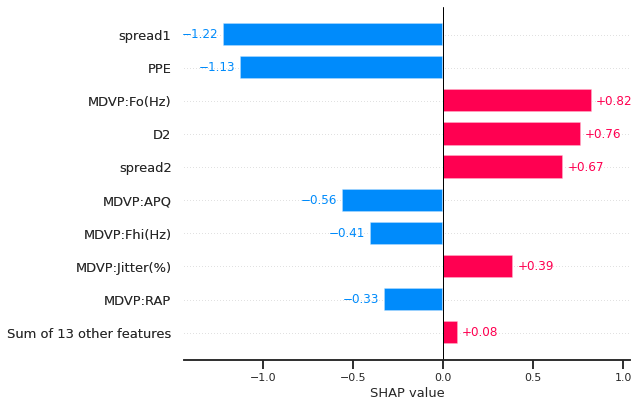

In [ ]:
shap.plots.bar(shap_values_bar[10]) # For the first observation

Compared with the waterfall plot, the bar plot centers at zero and shows the contributions of variables.

### Decision Plot


The  decision plot is a good choice when there are many predictors. 
- Shows a large number of feature effects clearly.
- Displays the cumulative effect of interactions.
- Identifies typical prediction paths.



The expected value is  1.6021717


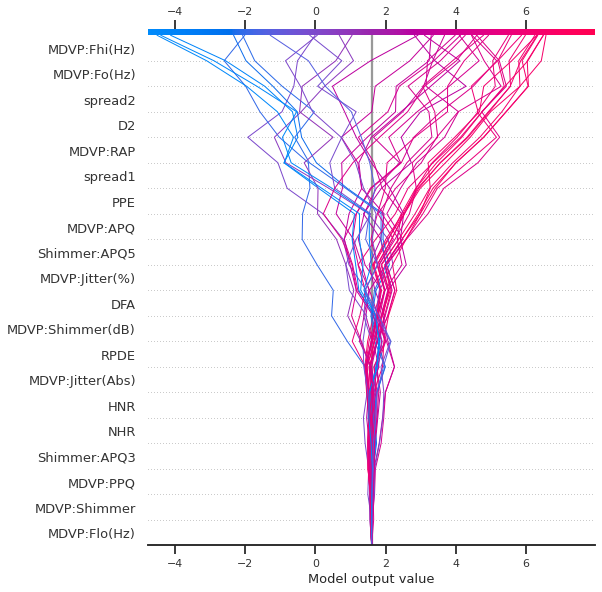

In [ ]:
expected_value = explainer_bar.expected_value
print("The expected value is ", expected_value)
shap_values = explainer_bar.shap_values(X_test)
shap.decision_plot(expected_value, shap_values, X_test)

- In the figure above, the line heads to the left or right given the forces of the predictors.
- The x-axis represents the model's output. 
- The plot is centered on the x-axis at expected value. 
- All SHAP values are relative to the model's expected value.
- The y-axis lists the model's features. 
- Features are ordered by descending importance. 
- Each observation's prediction is represented by a colored line. 
- At the top, each line strikes the x-axis at its corresponding observation's predicted value. This value determines the color of the line on a spectrum.
- Moving from the bottom to top, SHAP values for each feature are added to the model's base value. This shows how each feature contributes to the overall prediction. 



**Let's inspect the misclassified observation.**


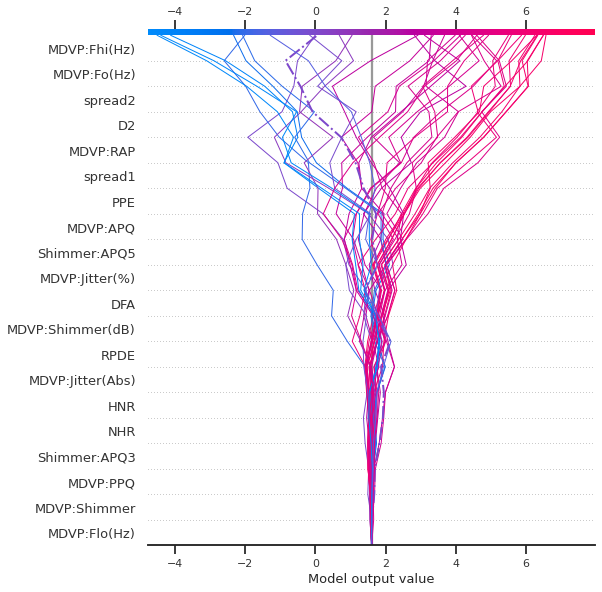

In [ ]:
y_pred1 = (shap_values.sum(1) + expected_value) > 0
misclassified = y_pred1 != y_test
shap.decision_plot(expected_value, shap_values, X_test, highlight=misclassified)
#shap.decision_plot(expected_value, shap_values, features_display, link='logit', highlight=misclassified)

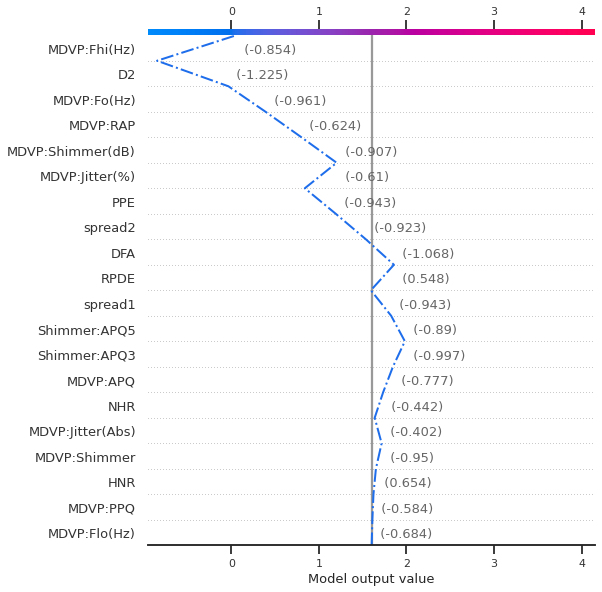

In [ ]:
# Let's inspect the misclassified observation by plotting it alone. 
# When a single observation is plotted, its corresponding feature values are displayed. 
# Notice that the shape of the line has changed. Why? The feature order has changed on 
# the y-axis based on the feature importance for this lone observation. 
# The section "Preserving order and scale between plots" shows how to use the same feature order for multiple plots.
shap.decision_plot(expected_value, shap_values[misclassified], X_test[misclassified], highlight=0)

In [ ]:
# A force plot for the misclassified observation is shown below. 
# In this case, the decision plot and the force plot are both effective at showing how the model arrived at its decision.
shap.initjs()
shap.force_plot(expected_value, shap_values[misclassified], X_test[misclassified], matplotlib=False)

**Decision Plot for Single Observation**


The expected value is  1.6021717


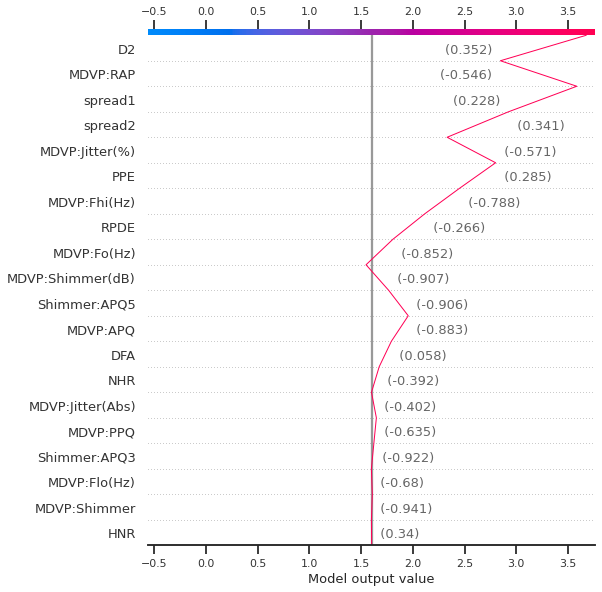

In [ ]:
expected_value = explainer_bar.expected_value
print("The expected value is ", expected_value)
shap_values = explainer_bar.shap_values(X_test)[0]
shap.decision_plot(expected_value, shap_values, X_test)

**Local Interpretability**
>**For a single prediction, what features in the data did the model think are most important?**

 


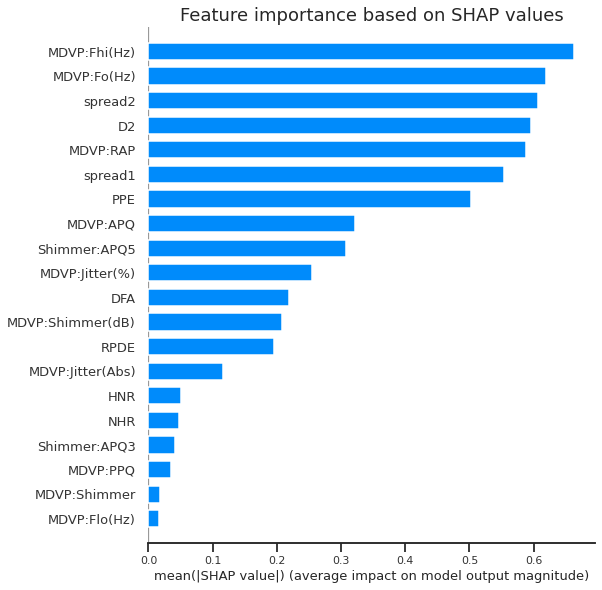

In [ ]:
plt.title('Feature importance based on SHAP values')
shap.summary_plot(shap_values, data_for_prediction, plot_type="bar")

##**SHAP Summary Plot - Global Interpretability**

- Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. 
- Features are sorted by the sum of the SHAP value magnitudes across all samples. 
- SHAP Summary Plot shows the feature impact on overall model prediction. So, we can get idea about how does each feature affect the model's predictions in a big-picture sense.

**Summary plot demonstrates the following:**
- Feature importance
 - Variables are ranked in descending order according to their
importance.
- Impact
 - The summary plot shows the top influential variables.
 - The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.




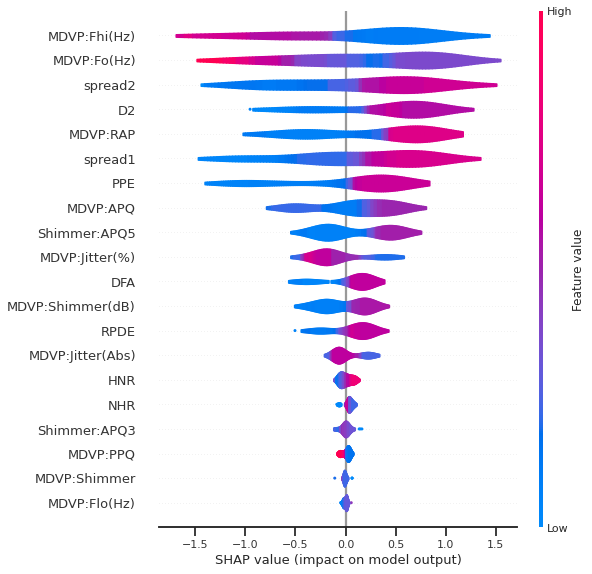

In [ ]:
#shap.summary_plot(shap_values, X,plot_type="layered_violin", color='coolwarm');
shap.summary_plot(shap_values, X_test,plot_type="violin");
#shap.summary_plot(shap_values, X_test)

- As shown above,variables are ranked in descending order according to their importance. The top influential variables are shown.

- The MDVP:Fhi variable has a high range of values and it has a low positive impact on status and high negative impact on status.
- A high level of the spread2 has a high and positive impact on the prediction. The “high” comes from the red color, and the “positive” impact is shown on the X-axis.

- HNR effects all predictions by a smaller amount.


##**The collective force plot - Global Interpretability** 
> **Visualizing many predictions**

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

**How does each feature affect the model's predictions in a big-picture sense?**

- In other words, what is its typical effect when considered over a large number of possible predictions

- Each observation has its own force plot. If all the force plots are combined, rotated 90 degrees and stacked horizontally, we get the force plot of the entire test data as shown above.

- Values that are red drive the output up. Values that are blue drive the output down.

- This plot is dense and there are many considerations to make:
 - The values are sorted by default in order of similarity. 
 - The sort order can be changed using the top dropdown to: similarity (default), output/target value, original order, or by any feature.
 - The left dropdown will allow us to filter to view the SHAP impact for a single feature.






##SHAP waterfall plot
- The waterfall plot is another local analysis plot of a single instance prediction.
- If we are interested to know why a case receives its prediction given its variable values, we can use the waterfall plot.
 



In [ ]:
import xgboost
import shap

# train XGBoost model  X_train, y_train
model111 = xgboost.XGBClassifier().fit(X_train, y_train)

# compute SHAP values
explainer111 = shap.Explainer(model111, X_train)
shap_values111 = explainer111(X_train)

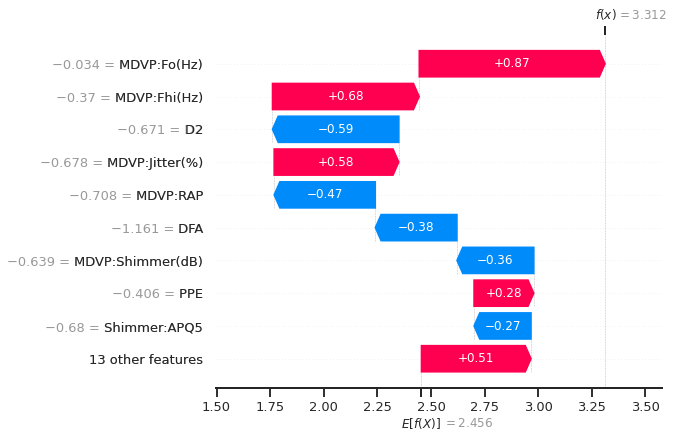

In [ ]:
shap.plots.waterfall(shap_values111[1])

- Starting from the base value in  bottom, add (red) or subtract (blue) values to get to the final prediction.

 - f(x) is the model predict_proba value: 3.312. 
 - E[f(x)] is the base value = 2.456, which is the average of all observations.

- On the left are the features value.
- On the arrows are the feature contribution to the prediction. 
- Each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the dataset to the model output for this prediction.
- Starting from the base value in  bottom, add (red) or subtract (blue) values to get to the final prediction.


In [ ]:
import warnings

In [ ]:
explainer_dp = shap.TreeExplainer(model111)
expected_value = explainer_dp.expected_value


if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(100) # row selected for fast runtime
features = X_train.iloc[select]
features_display = X_train.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values_dp = explainer_dp.shap_values(features)[1]
    shap_interaction_values = explainer_dp.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [1.6021716]


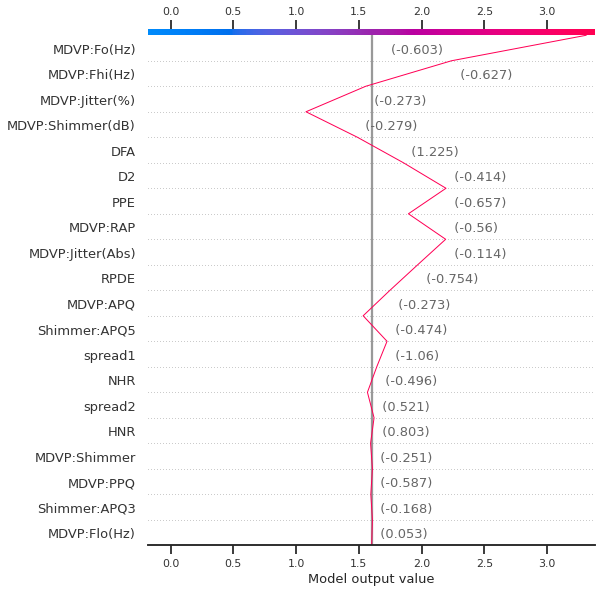

In [ ]:
#shap.decision_plot(expected_value, shap_values, features_display)
shap.decision_plot(expected_value, shap_values, features)

##**SHAP Dependence Plot — Global Interpretability**

- In the summary plot, we see the first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots to show the effect of a single feature across the whole dataset.
- It tells whether the relationship between the target and a feature is linear, monotonic or more complex.
- They plot a feature’s value vs. the SHAP value of that feature across many samples. 
- SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features and are only defined in regions of the input space supported by data. 
- The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.
- SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.


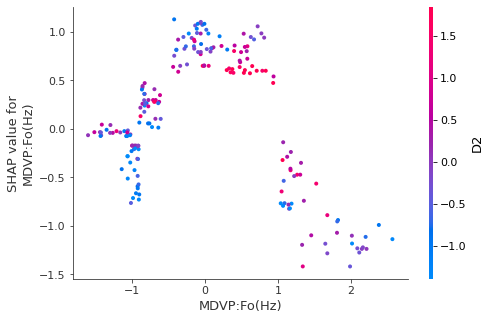

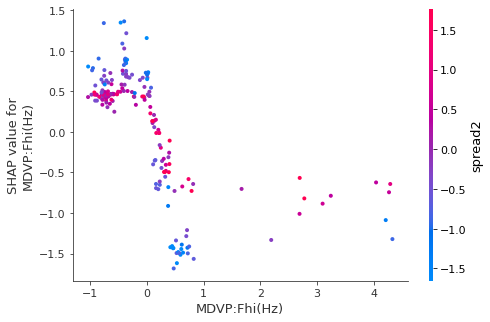

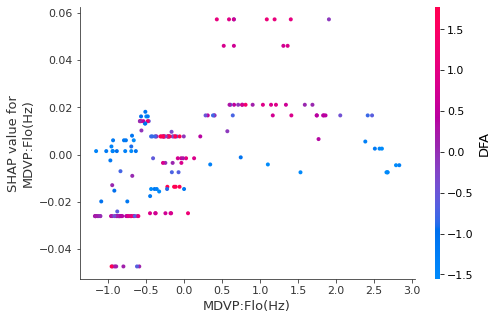

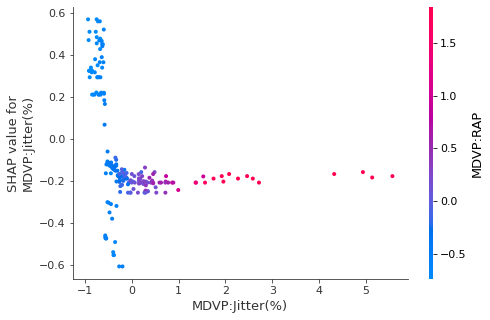

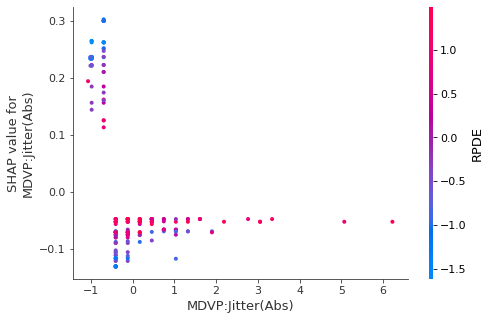

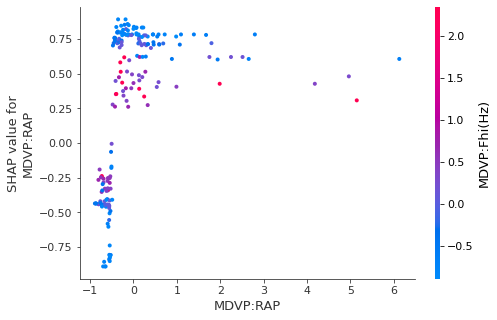

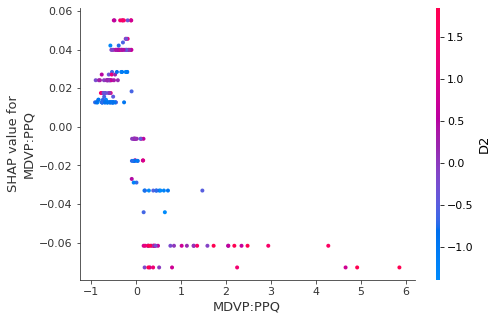

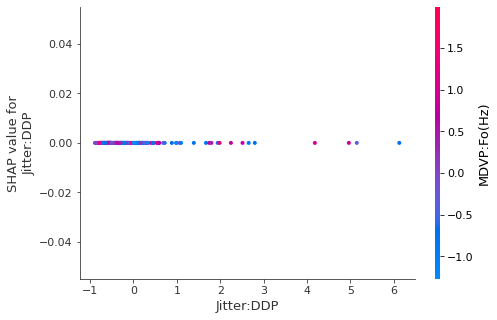

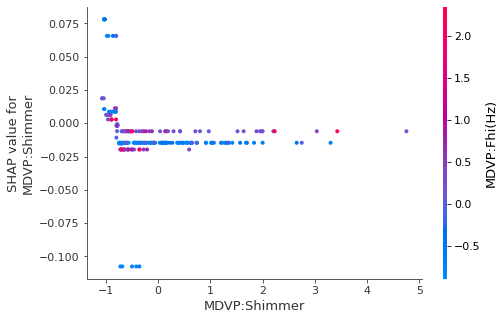

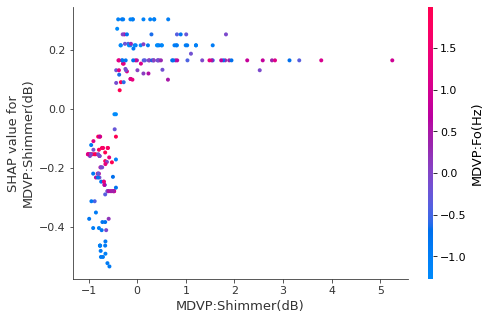

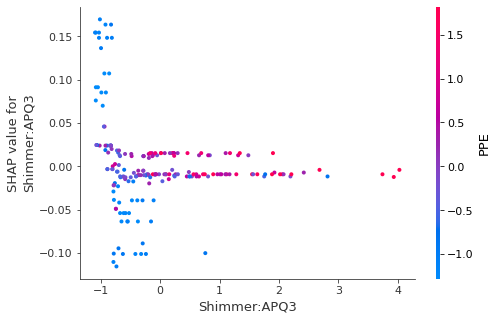

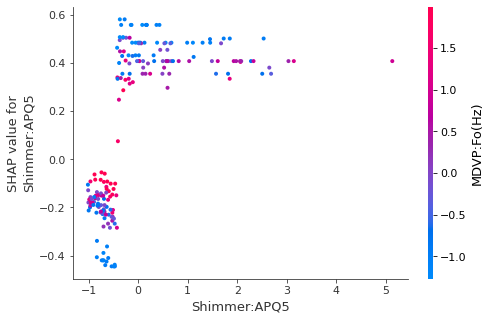

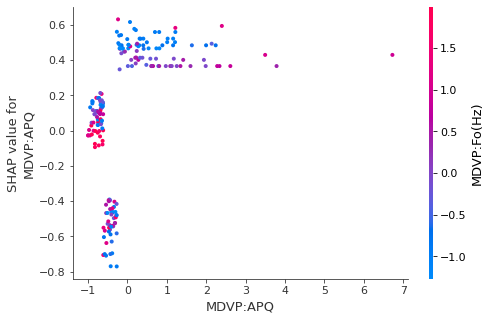

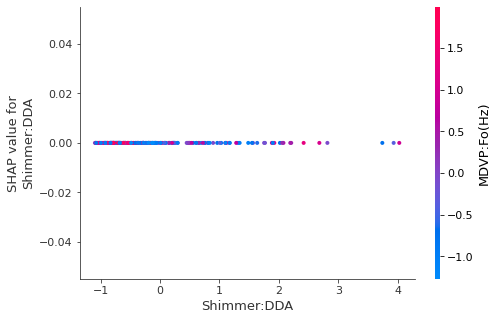

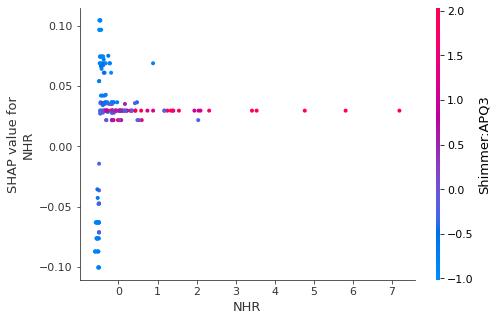

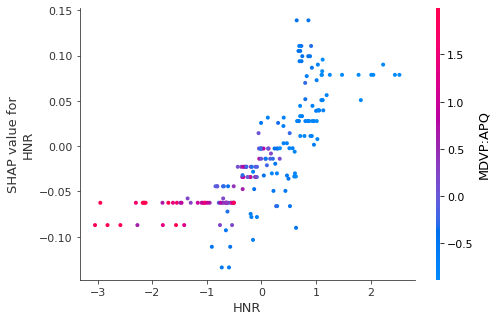

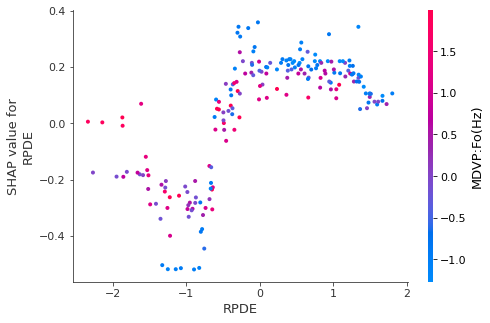

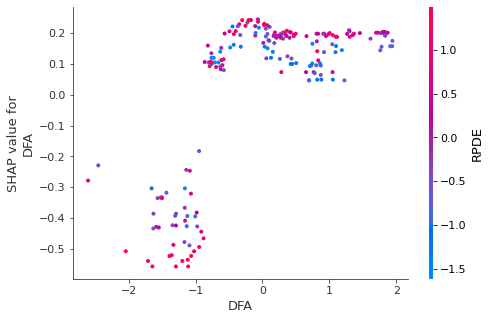

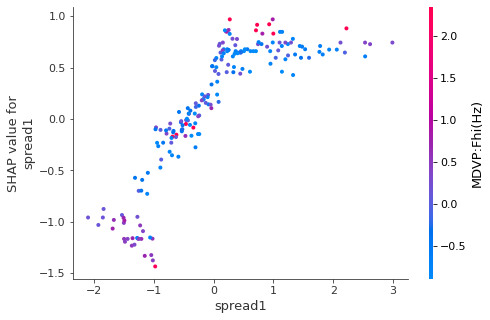

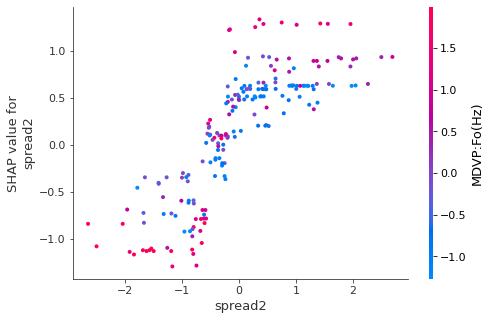

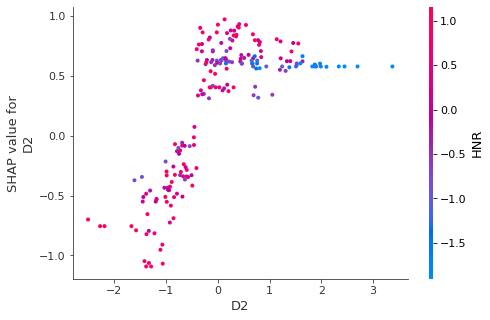

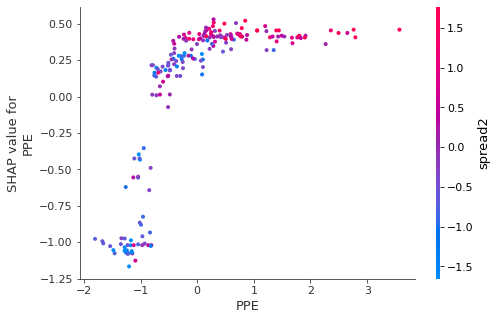

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)

#**XGBOOST Classifier With LIME Interpretability**

In [ ]:
# Define features vector X and target variable y
X1 = df.drop(['name','status'], axis=1)
y1 = df.status

feature_names = X1.columns


# Features normalizing
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)


# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size=0.8, shuffle=True, random_state=1)


In [ ]:
from xgboost import XGBClassifier

model1 = XGBClassifier()
model1.fit(X_train1, y_train1)

XGBClassifier()

In [ ]:
pip install lime

     |████████████████████████████████| 275 kB 9.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=7f2adf9a4454e9a42cdce34b26bbb1c36c282f3f1ab348e8eb97b5095b91229b
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# Prediction explanation with LIME
import lime 
from lime import lime_tabular

In [ ]:
limeparams = dict(training_data = X_train1, 
                  training_labels = y_train1.values, 
                  feature_names = feature_names, 
                  class_names = [0,1])
explainer = lime.lime_tabular.LimeTabularExplainer(**limeparams)

In [ ]:
RNIDX = 10

In [ ]:
exp1 = explainer.explain_instance(X_test1[RNIDX], model1.predict_proba, num_features = 12)

exp1.show_in_notebook(show_all=False)

- The output of LIME is a list of explanations, reflecting the contribution of each feature to the prediction of a data sample. 
- This provides local interpretability, and it also allows to determine which feature changes will have most impact on the prediction.


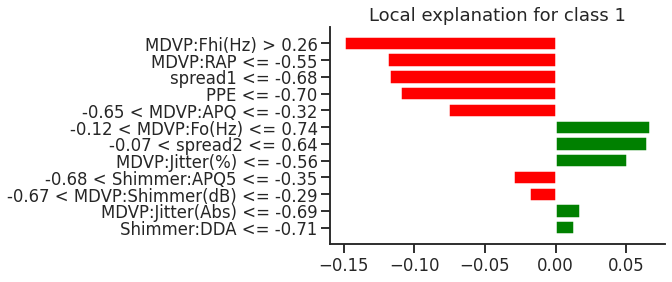

In [ ]:
exp1.as_pyplot_figure();

Features that have positive correlations with the target are shown in green, otherwise red.

#**Random Forest Classifier With SHAP & LIME**

# RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

RandomForestClassifier()

The accuracy score of RFC_base: 0.897

Training accuracy of RFC_base: 1.000

Test accuracy of RFC_base: 0.897

Sensitivity Score of RFC_base: 0.966

Specificity Score of RFC_base: 0.700

The roc_auc of RFC_base: 0.833

Classification report:

               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.90      0.97      0.93        29

    accuracy                           0.90        39
   macro avg       0.89      0.83      0.86        39
weighted avg       0.90      0.90      0.89        39

Confusion Matrix:


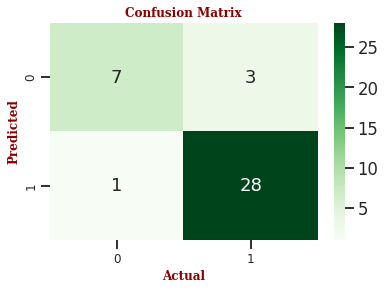

Summary of classification metrics:


Model  Training Accuracy  Test Accuracy  Sensitivity  Specificity  \
0  RFC_base                1.0       0.897436     0.965517          0.7   

    ROC_AUC  
0  0.832759

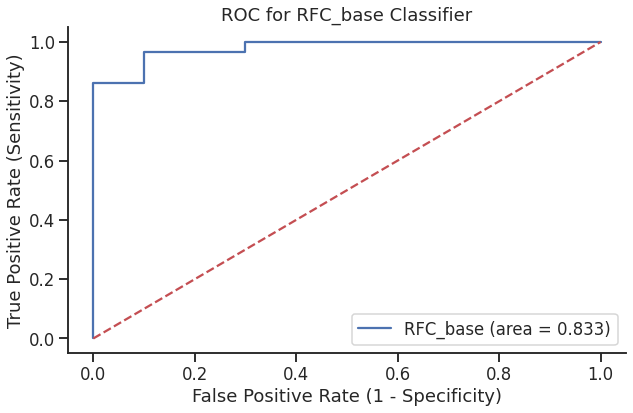

In [ ]:
RFC.fit(X_train, y_train)
#Predict Output
y_test_pred_RFC = RFC.predict(X_test)
y_train_pred_RFC = RFC.predict(X_train)

# Obtain Classification Mterics
model_name = 'RFC_base'
RFC_base_df = classification_metrics(y_test_pred_RFC, y_train_pred_RFC, y_train, y_test,model_name)

model_name = 'RFC_base'
roc_curve_plot(X_test, y_test, RFC,model_name)

In [ ]:
#Random Forest
RFC = RandomForestClassifier(random_state=42)

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }

CV_rfc = GridSearchCV(estimator= RFC, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 500}

In [ ]:
#rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [ ]:
RF = CV_rfc.best_estimator_

The accuracy score of RFC: 0.897

Training accuracy of RFC: 1.000

Test accuracy of RFC: 0.897

Sensitivity Score of RFC: 0.966

Specificity Score of RFC: 0.700

The roc_auc of RFC: 0.833

Classification report:

               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.90      0.97      0.93        29

    accuracy                           0.90        39
   macro avg       0.89      0.83      0.86        39
weighted avg       0.90      0.90      0.89        39

Confusion Matrix:


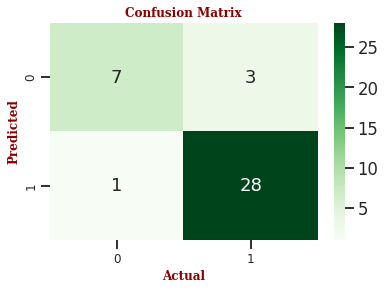

Summary of classification metrics:


Model  Training Accuracy  Test Accuracy  Sensitivity  Specificity   ROC_AUC
0   RFC                1.0       0.897436     0.965517          0.7  0.832759

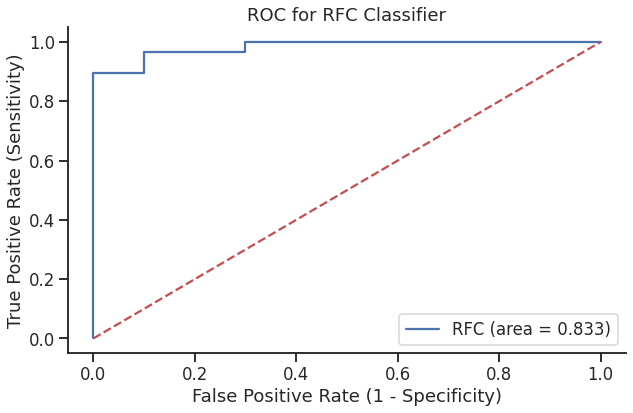

In [ ]:
#Predict Output
y_test_pred_RF = RF.predict(X_test)
y_train_pred_RF = RF.predict(X_train)

# Obtain Classification Mterics
model_name = 'RFC'
RFC_base_df = classification_metrics(y_test_pred_RF, y_train_pred_RF, y_train, y_test,model_name)

model_name = 'RFC'
roc_curve_plot(X_test, y_test, RF,model_name)

The accuracy score of RFC: 0.897

Training accuracy of RFC: 1.000

Test accuracy of RFC: 0.897

Sensitivity Score of RFC: 0.966

Specificity Score of RFC: 0.700

The roc_auc of RFC: 0.833

Classification report:

               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.90      0.97      0.93        29

    accuracy                           0.90        39
   macro avg       0.89      0.83      0.86        39
weighted avg       0.90      0.90      0.89        39

Confusion Matrix:


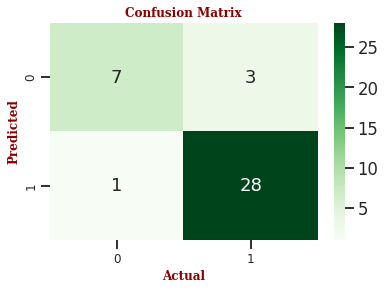

Summary of classification metrics:


Model  Training Accuracy  Test Accuracy  Sensitivity  Specificity   ROC_AUC
0   RFC                1.0       0.897436     0.965517          0.7  0.832759

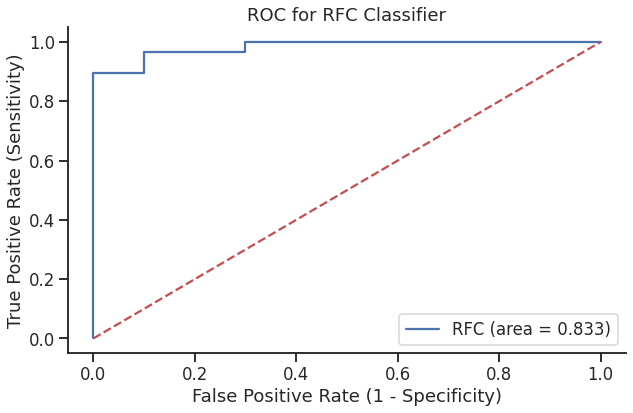

In [ ]:
#Random Forest
RFC = RandomForestClassifier(random_state=42, max_depth = 7,n_estimators = 500)
RFC.fit(X_train, y_train)
#Predict Output
y_test_pred_RFC = RFC.predict(X_test)
y_train_pred_RFC = RFC.predict(X_train)

# Obtain Classification Mterics
model_name = 'RFC'
RFC_base_df = classification_metrics(y_test_pred_RFC, y_train_pred_RFC, y_train, y_test,model_name)

model_name = 'RFC'
roc_curve_plot(X_test, y_test, RFC,model_name)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Random Forest
RFC = RandomForestClassifier(random_state=42, max_depth = 7,n_estimators = 500)
RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=500, random_state=42)

In [ ]:
random_forest_preds = RFC.predict(X_test)
print('The accuracy of the Random Forests model is :\t',accuracy_score(random_forest_preds,y_test))

The accuracy of the Random Forests model is :	 0.8974358974358975


In [ ]:
# Create Tree Explainer object that can calculate shap values
explainer_RFC = shap.TreeExplainer(RFC)

In [ ]:
# Use the explainer to explain predictions
# Calculate Shap values example 1
#Let's choose some instances from the test dataset to understand to the classifier makes predictions for them.
X_test.iloc[[0]]

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
132    -0.851972     -0.787799     -0.680255       -0.570852   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
132         -0.401899 -0.546056 -0.634603   -0.545009     -0.941017   

     MDVP:Shimmer(dB)  ...  MDVP:APQ  Shimmer:DDA      NHR       HNR  \
132          -0.90675  ... -0.883351    -0.922046 -0.39234  0.340482   

         RPDE      DFA   spread1   spread2        D2       PPE  
132 -0.265865  0.05814  0.228306  0.341364  0.352248  0.285437  

[1 rows x 22 columns]

In [ ]:
# Calculate Shap values
choosen_instance = X_test.iloc[[0]]
shap_values_RFC = explainer_RFC.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer_RFC.expected_value[1], shap_values_RFC[1], choosen_instance)

Interpretation :
What you see above is a force plot visualizing shapley values for the features. Feature values in pink cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect. Feature values in blue cause to decrease the prediction. Sum of all feature SHAP values explain why model prediction was different from the baseline.

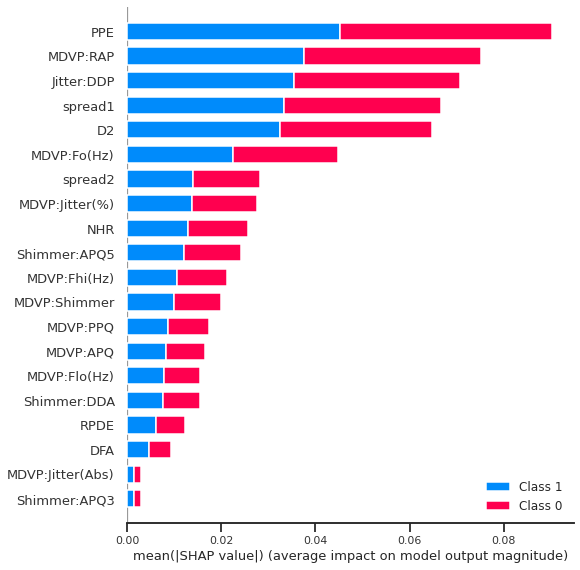

In [ ]:
shap.summary_plot(shap_values_RFC, X_train)

In [ ]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=[0, 1],
    mode='classification'
)

In [ ]:
test_1 = X_test.iloc[0]
lime_exp = lime_explainer.explain_instance(data_row=test_1, predict_fn=RFC.predict_proba, num_features = 12)
lime_exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
